In [2]:
# Read the main COMPAS dataset
import pandas as pd

# Read directly from the CSV file
df = pd.read_csv('compas-scores-two-years.csv')

# Basic data exploration
print(df.shape)
print(df.columns)
print(df.head())

# Check for missing values
print(df.isnull().sum())

(7214, 53)
Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')
   id                name   first     


Recidivism rates by race:
                  count      mean
race                             
African-American   3696  0.514340
Asian                32  0.281250
Caucasian          2454  0.393643
Hispanic            637  0.364207
Native American      18  0.555556
Other               377  0.352785

Recidivism rates by sex:
        count      mean
sex                    
Female   1395  0.356989
Male     5819  0.473105

Risk score distribution by race:
score_text             High        Low     Medium
race                                             
African-American  27.732684  41.179654  31.087662
Asian              9.375000  75.000000  15.625000
Caucasian         11.246944  65.199674  23.553382
Hispanic          10.518053  70.172684  19.309262
Native American   33.333333  33.333333  33.333333
Other              6.896552  79.045093  14.058355

False Positive Rates by race:
race
African-American    0.448468
Asian               0.086957
Caucasian           0.234543
Hispanic            0.

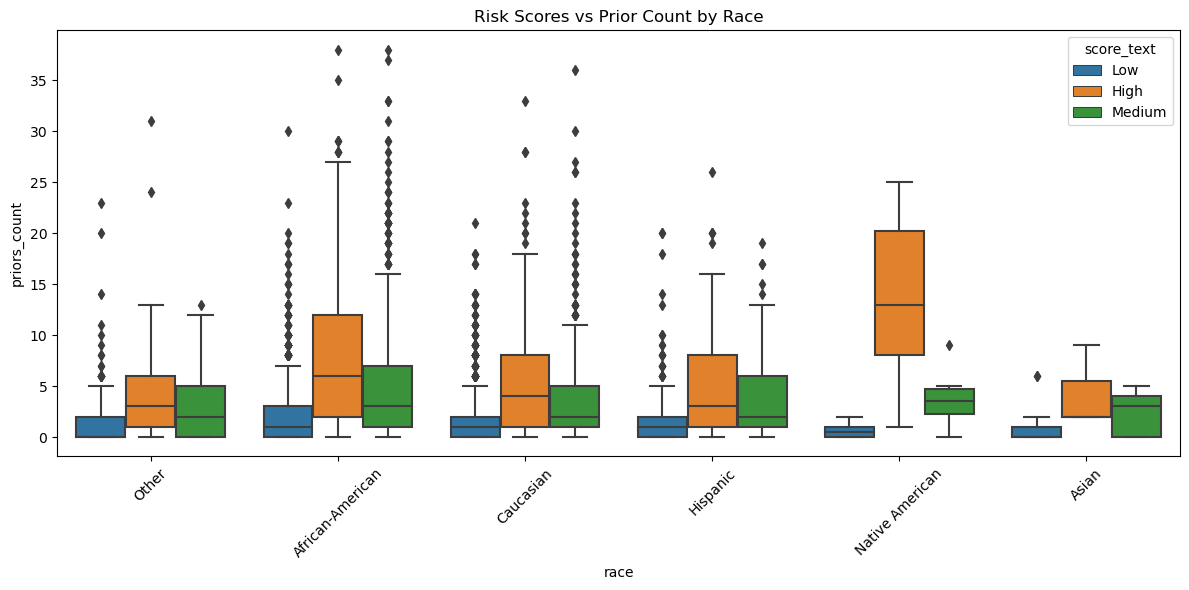


Disparate Impact Analysis (ratio of high-risk predictions):
race
African-American    1.690224
Asian               0.718384
Caucasian           1.000000
Hispanic            0.857099
Native American     1.915691
Other               0.602147
Name: is_high_risk, dtype: float64


In [3]:
# Previous code for data loading...

# Select relevant features and prepare data
columns_of_interest = [
    'age', 'sex', 'race', 'priors_count', 'c_charge_degree',
    'score_text', 'two_year_recid'
]
df = df[columns_of_interest]
df = df.dropna()

# 1. Basic demographic analysis
print("\nRecidivism rates by race:")
print(df.groupby('race')['two_year_recid'].agg(['count', 'mean']))

print("\nRecidivism rates by sex:")
print(df.groupby('sex')['two_year_recid'].agg(['count', 'mean']))

# 2. Risk score distribution analysis
print("\nRisk score distribution by race:")
print(pd.crosstab(df['race'], df['score_text'], normalize='index') * 100)

# 3. False Positive Rates by race
def calculate_fp_rate(group):
    # False positive rate: predicted high risk (Medium/High) but didn't reoffend
    fp = ((group['score_text'].isin(['Medium', 'High'])) & (group['two_year_recid'] == 0)).sum()
    actual_negative = (group['two_year_recid'] == 0).sum()
    return fp / actual_negative if actual_negative > 0 else 0

print("\nFalse Positive Rates by race:")
fp_rates = df.groupby('race').apply(calculate_fp_rate)
print(fp_rates)

# 4. False Negative Rates by race
def calculate_fn_rate(group):
    # False negative rate: predicted low risk but did reoffend
    fn = ((group['score_text'] == 'Low') & (group['two_year_recid'] == 1)).sum()
    actual_positive = (group['two_year_recid'] == 1).sum()
    return fn / actual_positive if actual_positive > 0 else 0

print("\nFalse Negative Rates by race:")
fn_rates = df.groupby('race').apply(calculate_fn_rate)
print(fn_rates)

# 5. Visualization of risk scores vs actual recidivism
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='race', y='priors_count', hue='score_text', data=df)
plt.title('Risk Scores vs Prior Count by Race')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. Calculate disparate impact
def calculate_disparate_impact(df, protected_attr, reference_group, outcome_column):
    rates = df.groupby(protected_attr)[outcome_column].mean()
    reference_rate = rates[reference_group]
    impact_ratios = rates / reference_rate
    return impact_ratios

print("\nDisparate Impact Analysis (ratio of high-risk predictions):")
df['is_high_risk'] = df['score_text'].isin(['Medium', 'High']).astype(int)
disparate_impact = calculate_disparate_impact(df, 'race', 'Caucasian', 'is_high_risk')
print(disparate_impact)


=== Recidivism Analysis ===


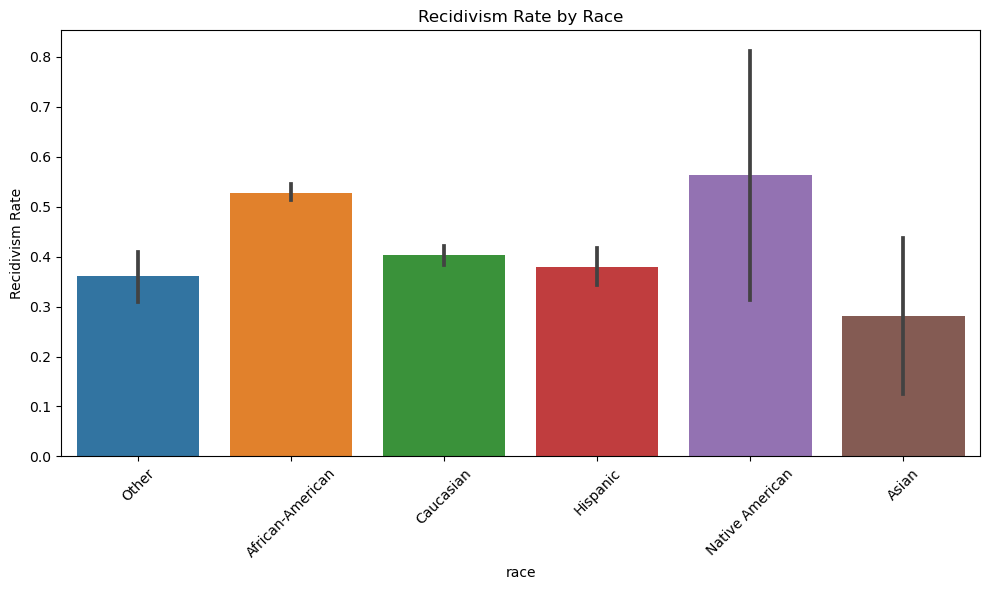

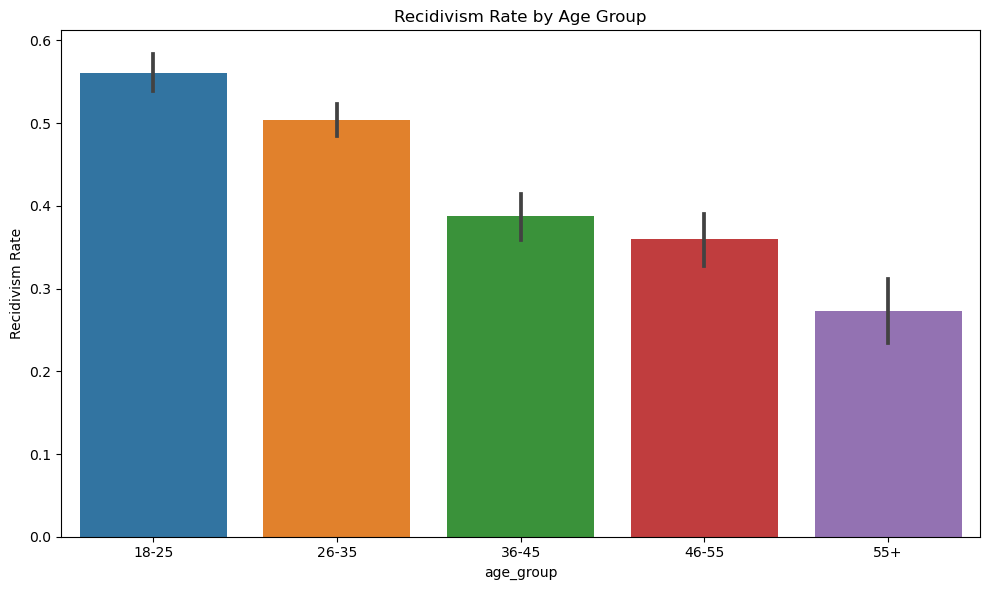


Recidivism rates by age group:
           count      mean
age_group                 
18-25       1811  0.560464
26-35       2473  0.503841
36-45       1250  0.387200
46-55        882  0.359410
55+          491  0.272912


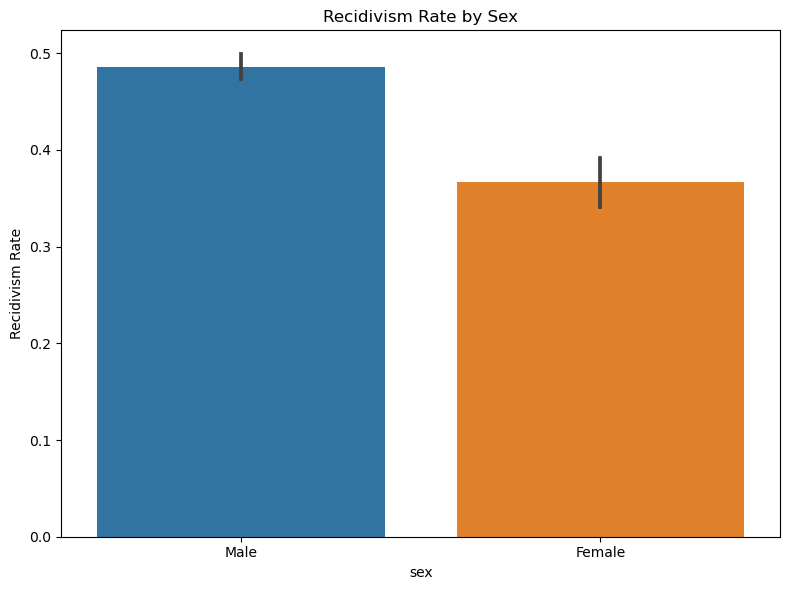

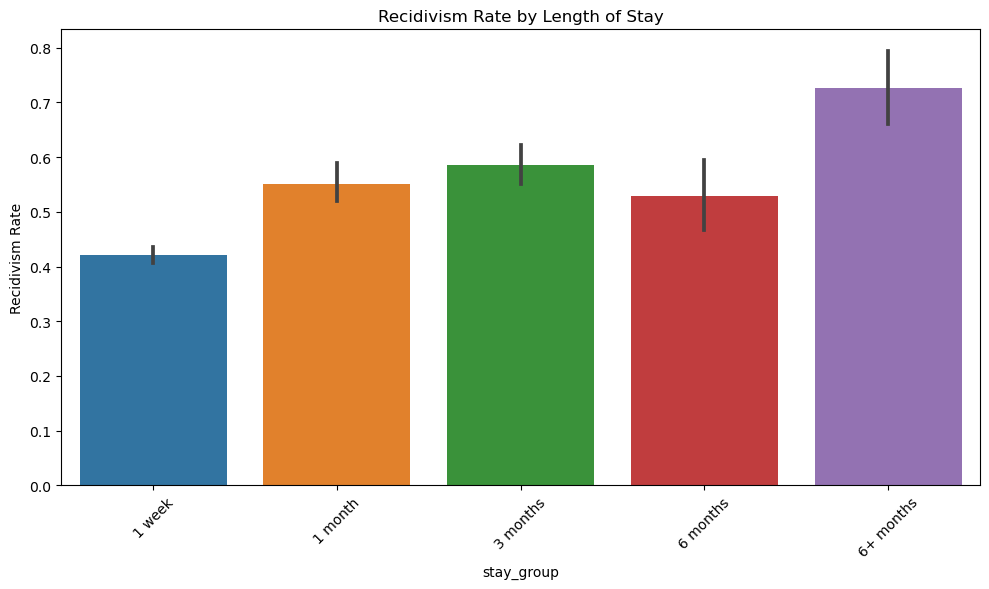


Recidivism rates by length of stay:
            count      mean
stay_group                 
1 week       4779  0.421009
1 month       819  0.550672
3 months      728  0.585165
6 months      210  0.528571
6+ months     165  0.727273

Correlation matrix:
                     age  length_of_stay  two_year_recid
age             1.000000        0.019532       -0.186686
length_of_stay  0.019532        1.000000        0.118378
two_year_recid -0.186686        0.118378        1.000000


In [6]:
df = pd.read_csv('compas-scores-two-years.csv')

# Convert jail dates to datetime
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])

# Calculate length of stay in days
df['length_of_stay'] = (df['c_jail_out'] - df['c_jail_in']).dt.total_seconds() / (24 * 60 * 60)

# Update columns of interest to include length_of_stay
columns_of_interest = [
    'age', 'sex', 'race', 'priors_count', 'c_charge_degree',
    'score_text', 'two_year_recid', 'length_of_stay'
]
df = df[columns_of_interest]
df = df.dropna()

# Analyze recidivism relationships with multiple variables
print("\n=== Recidivism Analysis ===")

# 1. Race and Recidivism (already included, but let's make it more visual)
plt.figure(figsize=(10, 6))
sns.barplot(x='race', y='two_year_recid', data=df)
plt.title('Recidivism Rate by Race')
plt.xticks(rotation=45)
plt.ylabel('Recidivism Rate')
plt.tight_layout()
plt.show()

# 2. Age and Recidivism
plt.figure(figsize=(10, 6))
# Create age bins for better visualization
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 45, 55, 100], labels=['18-25', '26-35', '36-45', '46-55', '55+'])
sns.barplot(x='age_group', y='two_year_recid', data=df)
plt.title('Recidivism Rate by Age Group')
plt.ylabel('Recidivism Rate')
plt.tight_layout()
plt.show()

# Print detailed statistics for age
print("\nRecidivism rates by age group:")
print(df.groupby('age_group')['two_year_recid'].agg(['count', 'mean']))

# 3. Sex and Recidivism
plt.figure(figsize=(8, 6))
sns.barplot(x='sex', y='two_year_recid', data=df)
plt.title('Recidivism Rate by Sex')
plt.ylabel('Recidivism Rate')
plt.tight_layout()
plt.show()

# 4. Length of Stay and Recidivism
plt.figure(figsize=(10, 6))
# Create length_of_stay bins (assuming it's in days)
df['stay_group'] = pd.cut(df['length_of_stay'], bins=[0, 7, 30, 90, 180, float('inf')], 
                         labels=['1 week', '1 month', '3 months', '6 months', '6+ months'])
sns.barplot(x='stay_group', y='two_year_recid', data=df)
plt.title('Recidivism Rate by Length of Stay')
plt.xticks(rotation=45)
plt.ylabel('Recidivism Rate')
plt.tight_layout()
plt.show()

# Print detailed statistics for length of stay
print("\nRecidivism rates by length of stay:")
print(df.groupby('stay_group')['two_year_recid'].agg(['count', 'mean']))

# 5. Correlation analysis for numerical variables
numerical_vars = ['age', 'length_of_stay', 'two_year_recid']
correlation_matrix = df[numerical_vars].corr()
print("\nCorrelation matrix:")
print(correlation_matrix)